In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install aif360

In [ ]:
# %cd drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
df_credit = pd.read_csv('data/german_credit_data.csv' , index_col=0)

In [ ]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)

# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)

df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [ ]:
#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Risk"]
del df_credit['Risk_bad']

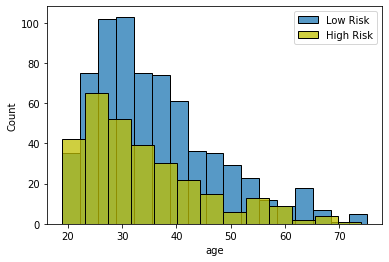

In [ ]:
x = pd.Series(df_credit[df_credit['Risk_good'] == 1]['Age'], name="age")
sns.histplot(x)
x = pd.Series(df_credit[df_credit['Risk_good'] == 0]['Age'], name="age")
sns.histplot(x, color='y')
plt.legend(labels=["Low Risk","High Risk"])

In [ ]:
#Let's look the Credit Amount column
interval = (18, 25, 120)

cats = ['young', 'old']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
del df_credit['Age_cat']
del df_credit['Age']

In [ ]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Housing_own', 'Housing_rent',
       'Savings_moderate', 'Savings_no_inf', 'Savings_quite rich',
       'Savings_rich', 'Risk_good', 'Check_moderate', 'Check_no_inf',
       'Check_rich', 'Sex_male', 'Age_cat_old'],
      dtype='object')

In [ ]:
df_credit.head(20)

,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,...,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Risk_good,Check_moderate,Check_no_inf,Check_rich,Sex_male,Age_cat_old
0,2,7.063904,6,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
1,2,8.691315,48,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,7.647786,12,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
3,2,8.972337,42,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,2,8.490849,24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,1,9.111072,36,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1
6,2,7.949797,24,0,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,1,1
7,3,8.846209,36,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,1
8,1,8.025843,12,0,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,1,1
9,3,8.562931,30,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [ ]:
X = df_credit.drop('Risk_good', axis=1).values
y = df_credit['Risk_good'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.885153 (0.064702)
KNN: 0.862822 (0.052355)


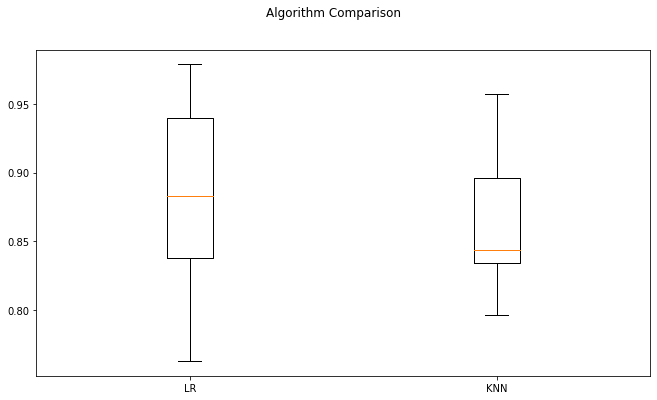

In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


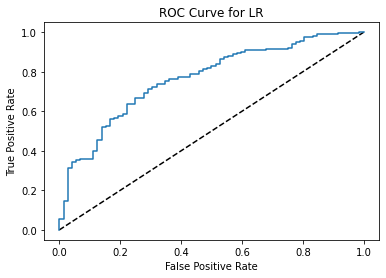

0.7643570536828963

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

name, model = models[0]
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for {}'.format(name))
plt.show()
roc_auc_score(y_test, y_pred_prob)

In [ ]:
#anti_classification
import copy
y_pred_prob = model.predict(X_test)

#Age
anti_class_X_test = copy.copy(X_test)
where_0 = np.where(anti_class_X_test[:,-1] == 0)
where_1 = np.where(anti_class_X_test[:,-1] == 1)



anti_class_X_test[where_0, -1] = 1
anti_class_X_test[where_1, -1] = 0

y_anti_class_prob = model.predict(anti_class_X_test)
print('anti-class inconsistency for age: ',np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))


#Gender
anti_class_X_test = copy.copy(X_test)
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)


# print(where_0)
anti_class_X_test[where_0, -2] = 1
anti_class_X_test[where_1, -2] = 0

y_anti_class_prob = model.predict(anti_class_X_test)
print('anti-class inconsistency for gender: ', np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

anti-class inconsistency for age:  38
anti-class inconsistency for gender:  12


In [ ]:
#Group Fairness
y_pred_prob = model.predict(X_test)
Total_entries = X_test.shape[0]
#Age group
where_0 = np.where(anti_class_X_test[:,-1] == 1)
where_1 = np.where(anti_class_X_test[:,-1] == 0)

adult_count = len(where_0[0])
young_count = Total_entries - adult_count

adult_pred_positive = np.sum(y_pred_prob[where_0])
young_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_adult = {} , Prob_young = {}'.format(adult_pred_positive/adult_count, young_pred_positive/young_count))

#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 1)
where_1 = np.where(anti_class_X_test[:,-2] == 0)

male_count = len(where_0[0])
female_count = Total_entries - male_count 

male_pred_positive = np.sum(y_pred_prob[where_0])
female_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_male = {} , Prob_female = {}'.format(male_pred_positive/male_count, female_pred_positive/female_count))

Group Fairness: Prob_adult = 0.8944723618090452 , Prob_young = 0.5686274509803921
Group Fairness: Prob_male = 0.7534246575342466 , Prob_female = 0.8587570621468926


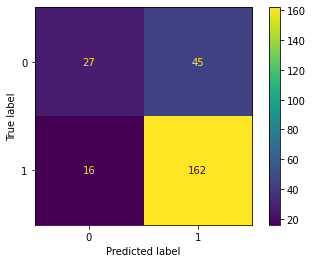

In [ ]:
#separation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_prob = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 1)
where_1 = np.where(anti_class_X_test[:,-2] == 0)

male_pred = y_pred_prob[where_0]
male_label = y_test[where_0]
cm_male = confusion_matrix(male_label, male_pred)

female_pred = y_pred_prob[where_1]
female_label = y_test[where_1]
cm_female = confusion_matrix(female_label, female_pred)

print('Separation for FPR: male-> {}, female-> {}'.format( cm_male[0][1]/(cm_male[0][0] + cm_male[0][1]),  cm_female[0][1]/(cm_female[0][0] + cm_female[0][1]) ))
print('Separation for FNR: male-> {}, female-> {}'.format( cm_male[1][0]/(cm_male[1][0] + cm_male[1][1]),  cm_female[1][0]/(cm_female[1][0] + cm_female[1][1]) ))

Separation for FPR: male-> 0.45454545454545453, female-> 0.7
Separation for FNR: male-> 0.11764705882352941, female-> 0.07874015748031496


In [ ]:
#Age
where_0 = np.where(anti_class_X_test[:,-1] == 1)
where_1 = np.where(anti_class_X_test[:,-1] == 0)

adult_pred = y_pred_prob[where_0]
adult_label = y_test[where_0]
cm_adult = confusion_matrix(adult_label, adult_pred)

young_pred = y_pred_prob[where_1]
young_label = y_test[where_1]
cm_young = confusion_matrix(young_label, young_pred)

print('Separation for FPR: adult-> {}, young-> {}'.format( cm_adult[0][1]/(cm_adult[0][0] + cm_adult[0][1]),  cm_young[0][1]/(cm_young[0][0] + cm_young[0][1]) ))
print('Separation for FNR: adult-> {}, young-> {}'.format( cm_adult[1][0]/(cm_adult[1][0] + cm_adult[1][1]),  cm_young[1][0]/(cm_young[1][0] + cm_young[1][1]) ))

Separation for FPR: adult-> 0.7454545454545455, young-> 0.23529411764705882
Separation for FNR: adult-> 0.04861111111111111, young-> 0.2647058823529412
